# Block Model: Layered background with three blocks

### Characteristics
- **Layered background** can be compared to 1D codes.
- **Simple blockmodel** as benchmark
- The blocks are an **adjusted version of the Dublin Test Model 1** (DTM1), Miensopust et al., 2013. Changes to the model include:
  - Added a layered background (instead of homogeneous background).
  - Converted to a shallow marine scenario, where the airwave is still dominantly present.
  - Layered background contains a shallow, isotropic layer, followed by a slightly
    anisotropic (VTI) background, and a deep strong resistor (e.g., basalt).
  - The blocks are made smaller in size (sort of MT to CSEM adaption):
      - all horizontal distances were divided by a factor of 5,
      - vertical distances by a factor of 20.
- Finite length source with:
  - electrode 1 (x, y, z) = (-100, 0, -550)
  - electrode 2 (x, y, z) = (100, 0, -550)
  - strength: 800 A  (=> 160 kAm moment)
  - frequency: 1 Hz
  
  
#### References
- Miensopust, M. P., P. Queralt, A. G. Jones, and the 3D MT modellers, 2013, Magnetotelluric 3-D inversion – a review of two successful workshops on forward and inversion code testing and comparison: Geophysical Journal International, 193, 1216–1238; DOI: [10.1093/gji/ggt066](https://doi.org/10.1093/gji/ggt066).

In [1]:
import discretize
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Create the model

### (a) Define the model

In [3]:
# 1D background
depth = [0., -600, -850, -3150]
res1d = [1e8, 0.3, 1, 2, 1000]
aniso = [1, 1, 1, np.sqrt(2), 1]

# Define dimensions of the three blocks [x1, x2, y1, y2, z1, z2]
block1 = [ -500,  500, -4000, 4000,  -1600, -850]
block2 = [    0, 5000, -3000,    0,  -1850, -1600]
block3 = [-5000,    0,     0, 3000, -2900, -1600]

# Resistivities Block 1, 2, and 3
resistivities = [10, 100, 500]

### (b) Create corresponding mesh

In [4]:
x0 = -10000
hx = np.diff(np.unique(np.r_[x0, block1[:2], block2[:2], block3[:2], -x0]))

y0 = -10000
hy = np.diff(np.unique(np.r_[y0, block1[2:4], block2[2:4], block3[2:4], -y0]))

z0 = -3400
hz = np.diff(np.unique(np.r_[z0, block1[4:], block2[4:], block3[4:], depth, 500]))

# Initiate the mesh
mesh = discretize.TensorMesh([hx, hy, hz], x0=np.array([x0, y0, z0]))

print("x-edges:", mesh.nodes_x)
print("y-edges:", mesh.nodes_y)
print("z-edges:", mesh.nodes_z)  # Includes background layers and blocks!
print("depths :", depth)          # Only layers

x-edges: [-10000.  -5000.   -500.      0.    500.   5000.  10000.]
y-edges: [-10000.  -4000.  -3000.      0.   3000.   4000.  10000.]
z-edges: [-3400. -3150. -2900. -1850. -1600.  -850.  -600.     0.   500.]
depths : [0.0, -600, -850, -3150]


### (c) Put model onto the mesh

In [5]:
# 1.A Initiate the horizontal and vertical resistivity models
resh = np.zeros(mesh.n_cells)
resv = np.zeros(mesh.n_cells)

# 1.B Define layered background model
resh[mesh.cell_centers[:, 2] > depth[0]] = res1d[0]              # Air
resv[mesh.cell_centers[:, 2] > depth[0]] = res1d[0]*aniso[0]**2
resh[mesh.cell_centers[:, 2] <= depth[0]] = res1d[1]             # Water
resv[mesh.cell_centers[:, 2] <= depth[0]] = res1d[1]*aniso[1]**2
resh[mesh.cell_centers[:, 2] <= depth[1]] = res1d[2]             # Overburden
resv[mesh.cell_centers[:, 2] <= depth[1]] = res1d[2]*aniso[2]**2
resh[mesh.cell_centers[:, 2] <= depth[2]] = res1d[3]             # Background
resv[mesh.cell_centers[:, 2] <= depth[2]] = res1d[3]*aniso[3]**2
resh[mesh.cell_centers[:, 2] <= depth[-1]] = res1d[-1]           # Basement
resv[mesh.cell_centers[:, 2] <= depth[-1]] = res1d[-1]*aniso[-1]**2

# Store as background resistivity
resh_bg = resh.copy()
resv_bg = resv.copy()

# 1.C Add the three blocks
for i, block in enumerate([block1, block2, block3]):
    block_i = (
        (mesh.cell_centers[:, 0] >= block[0]) & (mesh.cell_centers[:, 0] <= block[1]) &
        (mesh.cell_centers[:, 1] >= block[2]) & (mesh.cell_centers[:, 1] <= block[3]) &
        (mesh.cell_centers[:, 2] >= block[4]) & (mesh.cell_centers[:, 2] <= block[5])
    )
    resh[block_i] = resistivities[i]
    resv[block_i] = resistivities[i]
    
# Reshape them
resh = resh.reshape(mesh.shape_cells, order='F')
resv = resv.reshape(mesh.shape_cells, order='F')
resh_bg = resh_bg.reshape(mesh.shape_cells, order='F')
resv_bg = resv_bg.reshape(mesh.shape_cells, order='F')

### (d) Define survey

In [6]:
# Source: x-directed electric dipole of 200 m length, 50 meter above seafloor
src = np.array([-100., 100, 0, 0, -550, -550])
src_c = np.mean(src.reshape(-1, 2), 1)
strength = 800.0  # 800 A strength => 160 kAm source
freq = 1.0        # 1 Hz frequency

# 3 Receiver lines
rec_x = np.linspace(-10., 10, 101)*1e3
rec_y = np.array([-3., 0, 3])*1e3
rec_z = -600.0

### (e) QC

<IPython.core.display.Javascript object>


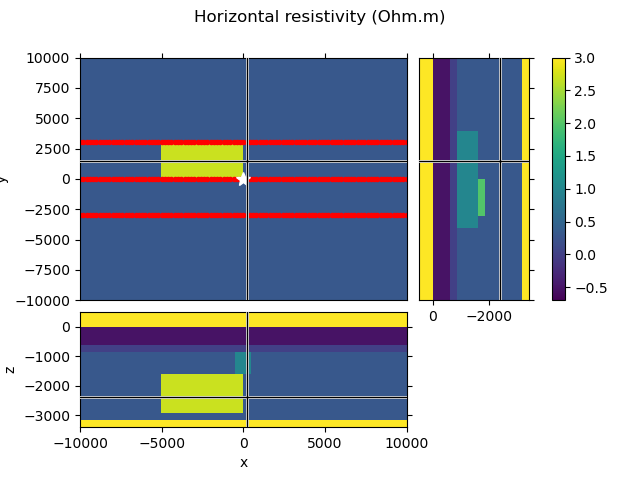

In [7]:
# Plot the resistivity model
fig = plt.figure()

mesh.plot_3d_slicer(np.log10(resh), clim=np.log10([0.2, 1000]),
                    zslice=-2500, fig=fig)

plt.suptitle('Horizontal resistivity (Ohm.m)')
axs = fig.get_children()[1]
axs.plot(rec_x, np.ones(rec_x.size)*rec_y[0], 'r.')
axs.plot(rec_x, np.ones(rec_x.size)*rec_y[1], 'r.')
axs.plot(rec_x, np.ones(rec_x.size)*rec_y[2], 'r.')
axs.plot(src_c[0], src_c[1], 'w*', ms=10, lw=3)
plt.show()

<IPython.core.display.Javascript object>


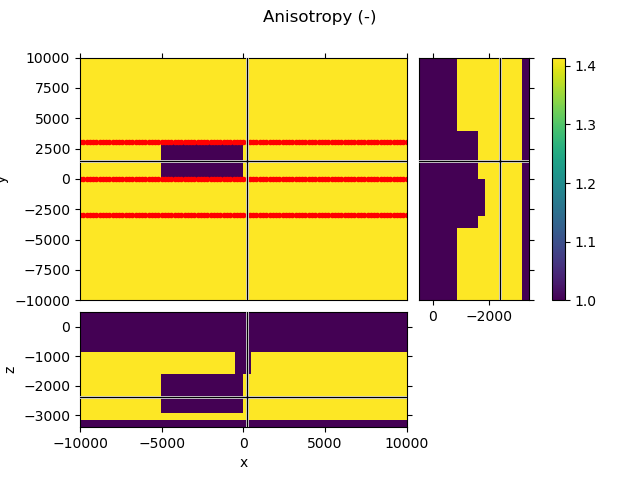

In [8]:
# Plot anisotropy
fig = plt.figure()

mesh.plot_3d_slicer(np.sqrt(resv/resh), zslice=-2500, fig=fig)

plt.suptitle('Anisotropy (-)')
axs = fig.get_children()[1]
axs.plot(rec_x, np.ones(rec_x.size)*rec_y[0], 'r.')
axs.plot(rec_x, np.ones(rec_x.size)*rec_y[1], 'r.')
axs.plot(rec_x, np.ones(rec_x.size)*rec_y[2], 'r.')
axs.plot(src_c[0], src_c[1], 'w', lw=3)
plt.show()

## Save survey

In [9]:
# Initiate data with zeros
dataset = {}
for i, y in enumerate(rec_y):
    lineid = f"line_{float(i+1):1.0f}"
    dataset[lineid] = xr.DataArray(
        data=np.zeros(2*rec_x.size, dtype=float),
        dims=['x'],
        coords={'x': np.vstack([rec_x, rec_x]).ravel('F')},
    )
    dataset[lineid].attrs['y'] = y

# Create a Dataset from the DataArray
ds = xr.Dataset(dataset)

# Add survey information
ds.attrs['src'] = src            # [x0, x1, y0, y1, z0, z1]
ds.attrs['strength'] = strength  # Source strength
ds.attrs['freq'] = freq          # Source frequency
ds.attrs['rec_theta'] = 0.0      # theta = 0
ds.attrs['rec_dip'] = 0.0        # dip = 0
ds.attrs['rec_y'] = rec_y        # all receiver y
ds.attrs['rec_z'] = rec_z        # all receiver z

# Add the model
ds.attrs['hx'] = mesh.h[0]
ds.attrs['hy'] = mesh.h[1]
ds.attrs['hz'] = mesh.h[2]
ds.attrs['x0'] = mesh.origin
ds.attrs['resh_bg'] = resh_bg
ds.attrs['resv_bg'] = resv_bg
ds.attrs['resh_tg'] = resh
ds.attrs['resv_tg'] = resv

# Add the extracted 1d model
ds.attrs['res1d'] = res1d
ds.attrs['aniso'] = aniso
ds.attrs['depth'] = depth

# Add meta data (see README for more info)
# We don't fill out all the meta data here, as this is
# only the survey and the model, no data computation
ds.attrs['runtime'] = 'N/A'
ds.attrs['n_procs'] = 'N/A'
ds.attrs['max_ram'] = 'N/A'
ds.attrs['n_cells'] = f"({mesh.shape_cells[0]} x {mesh.shape_cells[1]} x {mesh.shape_cells[2]}) - {mesh.n_cells}"
ds.attrs['n_nodes'] = 'N/A'
ds.attrs['n_dof'] = mesh.n_edges
ds.attrs['extent'] = (f"x = {mesh.nodes_x[0]:.1f}-{mesh.nodes_x[-1]:.1f}; " # Total mesh extent
                      f"y = {mesh.nodes_y[0]:.1f}-{mesh.nodes_y[-1]:.1f}; "
                      f"z = {mesh.nodes_z[0]:.1f}-{mesh.nodes_z[-1]:.1f}")
ds.attrs['min_vol'] = f"{np.min(mesh.cell_volumes):.1f}"
ds.attrs['max_vol'] = f"{np.max(mesh.cell_volumes):.1f}"
ds.attrs['machine'] = 'N/A'
ds.attrs['version'] = 'N/A'
ds.attrs['date'] = datetime.today().isoformat()

# Store to disk
ds.to_netcdf(f'block_model_and_survey.nc', engine='h5netcdf')

## Figure for manuscript

<IPython.core.display.Javascript object>


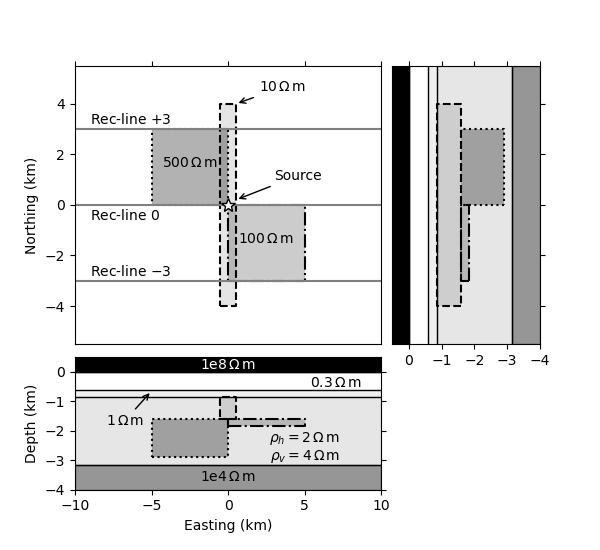

In [10]:
ls = ['--', '-.', ':']
alpha = [0.1, 0.2, 0.3]
# Background-alpha is a function of log10-resistivity
alphabg = (np.log10(res1d)-min(np.log10(res1d)))/max(np.log10(res1d)-min(np.log10(res1d)))
xlim = [-10, 10]
ylim = [-5.5, 5.5]
zlim = [-4, 0.5]

fig = plt.figure(figsize=(6, 5.5))
fig.subplots_adjust(wspace=.075, hspace=.1)

# X-Y
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=2) #, aspect='equal')

# Draw blocks
for i, b in enumerate([block1, block2, block3]):
    tg = plt.Rectangle((b[0]/1e3, b[2]/1e3),
                       np.diff(b[:2])[0]/1e3, np.diff(b[2:4])[0]/1e3,
                       facecolor="black", alpha=alpha[i])
    ax1.add_patch(tg)
    plt.plot(np.r_[b[:2], b[1::-1], b[0]]/1e3,
             np.r_[2*[b[2]], 2*[b[3]], b[2]]/1e3, f'k{ls[i]}')

# Annotate block resistivities
plt.annotate(r'$10\,\Omega\,$m', (0.5, 4), xytext=(2, 4.5), arrowprops=dict(arrowstyle="->"))
plt.text(2.5, -1.5, r'$100\,\Omega\,$m', horizontalalignment='center')
plt.text(-2.5, 1.5, r'$500\,\Omega\,$m', horizontalalignment='center')
plt.text(-9, -0.6, 'Rec-line $0$')
plt.text(-9, 3.2, r'Rec-line $+3$')
plt.text(-9, -2.8, r'Rec-line $-3$')
plt.annotate('Source', (0.5, 0.2), xytext=(3, 1), arrowprops=dict(arrowstyle="->"))
    
# Plot source and receiver lines
for y in rec_y:
    plt.axhline(y/1e3, c='.5')
plt.plot(0, 0, '*', ms=10, mfc='w', mec='k')
    
ax1.set_ylabel('Northing (km)')
ax1.set_xlim([xlim[0], xlim[1]])
ax1.set_ylim([ylim[0], ylim[1]])
ax1.xaxis.set_ticks_position('top')
plt.setp(ax1.get_xticklabels(), visible=False)

# X-Z
ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=2, rowspan=1, sharex=ax1)
ax2.yaxis.set_ticks_position('both')

# Draw layered background
prev = zlim[1]
for i, d in enumerate(np.r_[depth, zlim[0]*1e3]):
    plt.fill_between([xlim[0], xlim[1]], [prev, prev],
                     [d/1e3, d/1e3],
                     color='k', alpha=alphabg[i])
    if i < 4:
        plt.axhline(d/1e3, c='k', lw=1)
    prev = d/1e3
    
# Draw blocks
for i, b in enumerate([block1, block2, block3]):
    tg = plt.Rectangle((b[0]/1e3, b[4]/1e3),
                       np.diff(b[:2])[0]/1e3, np.diff(b[4:])[0]/1e3,
                       facecolor="black", alpha=alpha[i])
    ax2.add_patch(tg)
    plt.plot(np.r_[b[:2], b[1::-1], b[0]]/1e3,
             np.r_[2*[b[4]], 2*[b[5]], b[4]]/1e3, f'k{ls[i]}')

# Annotate background resistivities
plt.text(0, 0.1, r'1e8$\,\Omega\,$m', c='w', horizontalalignment='center')
plt.text(7, -0.5, r'0.3$\,\Omega\,$m', horizontalalignment='center')
plt.annotate(r'1$\,\Omega\,$m', (-5, -0.65), xytext=(-8, -1.8), arrowprops=dict(arrowstyle="->"))
plt.text(5, -2.4, r'$\rho_h=2\,\Omega\,$m', horizontalalignment='center')
plt.text(5, -3, r'$\rho_v=4\,\Omega\,$m', horizontalalignment='center')
plt.text(0, -3.7, r'1e4$\,\Omega\,$m', horizontalalignment='center')

ax2.set_xlabel('Easting (km)')
ax2.set_xlim([xlim[0], xlim[1]])
ax2.set_ylabel('Depth (km)')
ax2.set_ylim([zlim[0], zlim[1]])
ax2.set_yticks([0, -1, -2, -3, -4])

# Z-Y
ax3 = plt.subplot2grid((3, 3), (0, 2), colspan=1, rowspan=2, sharey=ax1)

# Draw layered background
prev = zlim[1]
for i, d in enumerate(np.r_[depth, zlim[0]*1e3]):
    plt.fill_betweenx([ylim[0], ylim[1]], [prev, prev],
                     [d/1e3, d/1e3],
                     color='k', alpha=alphabg[i])
    if i < 4:
        plt.axvline(d/1e3, c='k', lw=1)
    prev = d/1e3
    
# Draw blocks
for i, b in enumerate([block1, block2, block3]):
    tg = plt.Rectangle((b[4]/1e3, b[2]/1e3),
                       np.diff(b[4:])[0]/1e3, np.diff(b[2:4])[0]/1e3,
                       facecolor="black", alpha=alpha[i])
    ax3.add_patch(tg)
    plt.plot(np.r_[b[4:], b[-1:3:-1], b[4]]/1e3,
             np.r_[2*[b[2]], 2*[b[3]], b[2]]/1e3, f'k{ls[i]}')

ax3.yaxis.set_ticks_position('right')
ax3.xaxis.set_ticks_position('both')
ax3.invert_xaxis()
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.set_ylim([ylim[0], ylim[1]])
ax3.set_xlim([zlim[1], zlim[0]])
ax3.set_xticks([0, -1, -2, -3, -4])

plt.savefig('../manuscript/figures/model-block.pdf', bbox_inches='tight')
plt.show()

In [11]:
import scooby
scooby.Report([discretize, xr])

--------------------------------------------------------------------------------
  Date: Thu Jan 28 13:18:50 2021 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GB
       Environment : Jupyter

  Python 3.8.0 | packaged by conda-forge | (default, Nov 22 2019, 19:11:38)
  [GCC 7.3.0]

        discretize : 0.6.2
            xarray : 0.16.2
             numpy : 1.19.5
             scipy : 1.6.0
           IPython : 7.19.0
        matplotlib : 3.3.3
            scooby : 0.5.6

  Intel(R) Math Kernel Library Version 2020.0.4 Product Build 20200917 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------